In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

import healpy as hp

import src.observing as OBS
import src.sky_models as SM
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.beam_functions as BF
import src.map_making as MM
from src.blockmat import BlockMatrix, BlockVector

RS = SH.RealSphericalHarmonics()

In [51]:
def plot_reconstruction(fg_seed=101):
    """
    Plot the reconstruction of the monopole mode with the mapmaking method, with both total errors
    and noise-only errors.

    Hopefully what I'll show is that the error bars from the C_a matrix appear too large because
    they act as a single data point, but when only the noise errors are plotted, they do not seem
    too large.
    """
    basemap_err = 10
    err_type='idx'
    
    nside = 32
    lmax  = 32
    lmod  = 5
    Nlmax = RS.get_size(lmax)
    Nlmod = RS.get_size(lmod)
    
    # Observation and binning params.
    Ntau  = None
    Nt    = 24
    times = np.linspace(0, 24, Nt, endpoint=False)
    nuarr = np.linspace(50,100,51)
    lats = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
    
    # Cosmological parameters.
    cm21_params = OBS.cm21_params
    
    # Foreground correction reference frequency.
    err_ref = 70
    
    # Generate foreground and 21-cm signal alm
    cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_params)
    fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, 
        use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err, ref_freq=err_ref), 
        err_type=err_type, seed=fg_seed, meancorr=False)
    fid_alm = fg_alm + cm21_alm
    
    # Generate observation matrix for the modelling and for the observations.
    narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)
    mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)
    mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
    mat_A_mod = mat_A[:,:Nlmod]
    mat_A_unmod = mat_A[:,Nlmod:]
    
    # Perform fiducial observations
    d = mat_A @ fid_alm
    dnoisy, noise_covar = SM.add_noise(d, 1, Ntau=len(times), t_int=101, seed=456)
    
    # Generate a missing-modes correction analytically.
    alm_mean, alm_cov = SM.gsma_corr(lmod, lmax, nside, nuarr, basemap_err, ref_freq=err_ref)
    data_corr = mat_A_unmod @ alm_mean
    covar_corr = mat_A_unmod @ (alm_cov/1) @ mat_A_unmod.T

    # Compute the noise-only contribution of the alm uncertainty (a bit heuristic).
    mat_W_noiseonly, cov_noise = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=noise_covar, cov=True, cond=True)
    alm_error_noiseonly = np.sqrt(cov_noise.diag)

    # Compute the corrected mode-only contribution of the alm uncertainty (a bit heuristic).
    _, cov_corr_modes = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=covar_corr, cov=True, cond=True)
    alm_error_corr_modesonly = np.sqrt(cov_corr_modes.diag)

    
    # Reconstruct the max likelihood estimate of the alm
    mat_W, cov = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=noise_covar+covar_corr, cov=True, cond=True)
    alm_error = np.sqrt(cov.diag)
    rec_alm = mat_W @ (dnoisy - data_corr)


    # Plot the recovered alm.
    rec = rec_alm[0]
    tot = BlockVector(fid_alm, nblock=len(nuarr))[0]
    err = BlockVector(alm_error, nblock=len(nuarr))[0]
    err_noiseonly = BlockVector(alm_error_noiseonly, nblock=len(nuarr))[0]
    err_corr_modesonly = BlockVector(alm_error_corr_modesonly, nblock=len(nuarr))[0]
    plt.errorbar(nuarr, rec-tot, err, fmt='.')
    plt.errorbar(nuarr, rec-tot, err_corr_modesonly, fmt='.')
    plt.errorbar(nuarr, rec-tot, err_noiseonly, fmt='.')
    plt.axhline(0, color='k', linestyle=':')
    zero_outliers = ((rec-tot)**2 > err_corr_modesonly**2).sum()
    print((rec-tot)**2 > err_corr_modesonly**2)
    print(f"zero-outliers = {zero_outliers}")

    # Fit a log-polynomial to the data.
    def fg_polymod(nuarr, *theta_fg):
        Afg, alpha = theta_fg[:2]
        zetas      = theta_fg[2:]
        exponent = [zetas[i]*np.log(nuarr/60)**(i+2) for i in range(len(zetas))]
        fg_a00_terms = (Afg)*(nuarr/60)**(-alpha) * np.exp(np.sum(exponent, 0))
        return fg_a00_terms

    fit, _ = curve_fit(fg_polymod, nuarr, rec-tot, sigma=err_noiseonly, p0=[0.1,0.1])
    bestfit_line = fg_polymod(nuarr, *fit)
    plt.plot(nuarr, bestfit_line)
    plt.show()

    plt.errorbar(nuarr, rec-tot-bestfit_line, err_noiseonly, fmt='.')
    plt.axhline(0, color='k', linestyle=':')
    outliers = ((rec-tot-bestfit_line)**2 > (err_noiseonly)**2).sum()
    print(((rec-tot-bestfit_line)**2 > (err_noiseonly)**2))
    print(f"Noutliers = {outliers}, which is {100*outliers/50} percent")
    plt.show()
    
        

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<10>
1/condition #: 6.914199092511732e-08
1/condition #: 2.3708455422873863e-09
1/condition #: 2.66062453254824e-09
[False False False False  True False False  True False False  True False
 False False False  True False False False False False False False False
 False False False  True False  True  True False False False False False
 False False False False False False False False False False False False
 False False False]
zero-outliers = 7


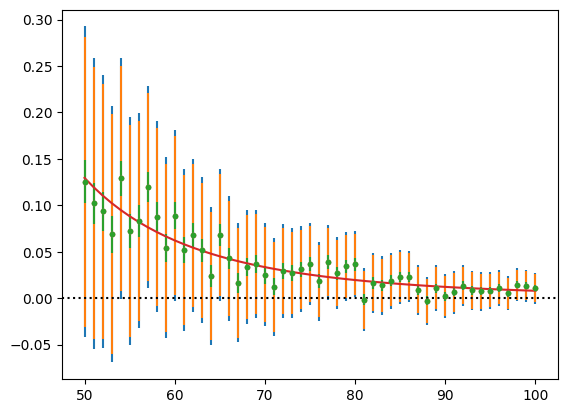

[False False False  True  True False False  True  True False  True False
 False False  True  True False  True False False False  True False False
 False  True False  True False  True  True  True False False False  True
  True False  True False  True  True False False False False False False
  True  True False]
Noutliers = 21, which is 42.0 percent


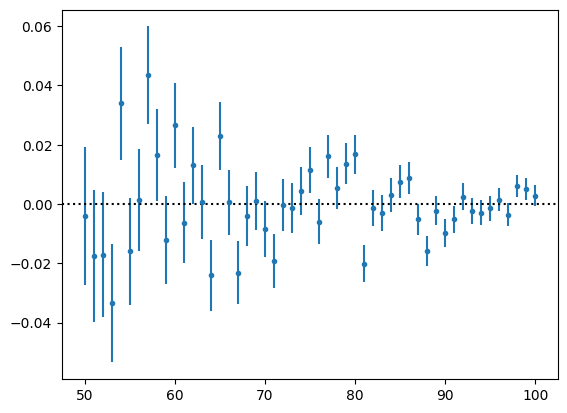

In [52]:
plot_reconstruction(101)

[ True False  True  True False False False  True False False False  True
 False False False  True False  True  True  True False False  True False
  True  True False  True False False False False False False False False
  True False  True False False False  True False  True False False  True
 False False]
Noutliers = 18, which is 36.0 percent


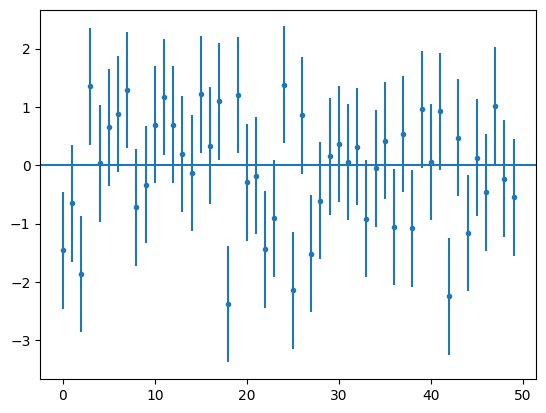

In [30]:
xx = list(range(50))
yy = np.random.randn(50)
sigmas = np.array([1]*50)


outliers = ((yy)**2 > (sigmas)**2).sum()
print(((yy)**2 > (sigmas)**2))
print(f"Noutliers = {outliers}, which is {100*outliers/50} percent")

plt.errorbar(xx,yy,1,fmt='.')
plt.axhline(0)
plt.show()

In [47]:
def zero_outlier_counter(fg_seed=101):
    """
    Do the reconstruction and return the number of datapoints above 1sigma away from
    zero. Hopefully across a lot of foreground seeds, this will average out to ~32%.
    """
    basemap_err = 10
    err_type='idx'
    
    nside = 32
    lmax  = 32
    lmod  = 5
    Nlmax = RS.get_size(lmax)
    Nlmod = RS.get_size(lmod)
    
    # Observation and binning params.
    Ntau  = None
    Nt    = 24
    times = np.linspace(0, 24, Nt, endpoint=False)
    nuarr = np.linspace(50,100,51)
    lats = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
    
    # Cosmological parameters.
    cm21_params = OBS.cm21_params
    
    # Foreground correction reference frequency.
    err_ref = 70
    
    # Generate foreground and 21-cm signal alm
    cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_params)
    fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, 
        use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err, ref_freq=err_ref), 
        err_type=err_type, seed=fg_seed, meancorr=False)
    fid_alm = fg_alm + cm21_alm
    
    # Generate observation matrix for the modelling and for the observations.
    narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)
    mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)
    mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
    mat_A_mod = mat_A[:,:Nlmod]
    mat_A_unmod = mat_A[:,Nlmod:]
    
    # Perform fiducial observations
    d = mat_A @ fid_alm
    dnoisy, noise_covar = SM.add_noise(d, 1, Ntau=len(times), t_int=101, seed=456)
    
    # Generate a missing-modes correction analytically.
    alm_mean, alm_cov = SM.gsma_corr(lmod, lmax, nside, nuarr, basemap_err, ref_freq=err_ref)
    data_corr = mat_A_unmod @ alm_mean
    covar_corr = mat_A_unmod @ (alm_cov/1) @ mat_A_unmod.T
    
    # Reconstruct the max likelihood estimate of the alm
    mat_W, cov = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=noise_covar+covar_corr, cov=True, cond=True)
    alm_error = np.sqrt(cov.diag)
    rec_alm = mat_W @ (dnoisy - data_corr)

    # Compute the corrected mode-only contribution of the alm uncertainty (a bit heuristic).
    _, cov_corr_modes = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=covar_corr, cov=True, cond=True)
    alm_error_corr_modesonly = np.sqrt(cov_corr_modes.diag)

    # Compute zero-outliers and return them.
    rec = rec_alm[0]
    tot = BlockVector(fid_alm, nblock=len(nuarr))[0]
    err = BlockVector(alm_error, nblock=len(nuarr))[0]
    err_corr_modesonly = BlockVector(alm_error_corr_modesonly, nblock=len(nuarr))[0]
    zero_outliers = ((rec-tot)**2 > err_corr_modesonly**2).sum()
    
    return zero_outliers

In [48]:
ii = list(range(40))
total_points = 0
num_outliers = 0
for i in ii:
    num_outliers += zero_outlier_counter(i+100)
    total_points += 50
    print("percentage total outliers so far:", 100*num_outliers/total_points)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<10>
1/condition #: 2.6598444013153635e-09
1/condition #: 2.3708455422873863e-09
percentage total outliers so far: 0.0
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<10>
1/condition #: 2.66062453254824e-09
1/condition #: 2.3708455422873863e-09
percentage total outliers so far: 7.0
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<10>
1/condition #: 2.6606755239956697e-09
1/condition #: 2.3708455422873863e-09
percentage total outliers so far: 4.666666666666667
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<10>
1/condition #: 2.660337836145742e-09
1/condition #: 2.3708455422873863e-09
percentage total outliers so fa

KeyboardInterrupt: 

In [12]:
rec = rec_alm[0]
tot = BlockVector(fid_alm, nblock=len(nuarr))[0]
fgs = BlockVector(fg_alm, nblock=len(nuarr))[0]
c21 = BlockVector(cm21_alm, nblock=len(nuarr))[0]
err = BlockVector(alm_error, nblock=len(nuarr))[0]

<ErrorbarContainer object of 3 artists>

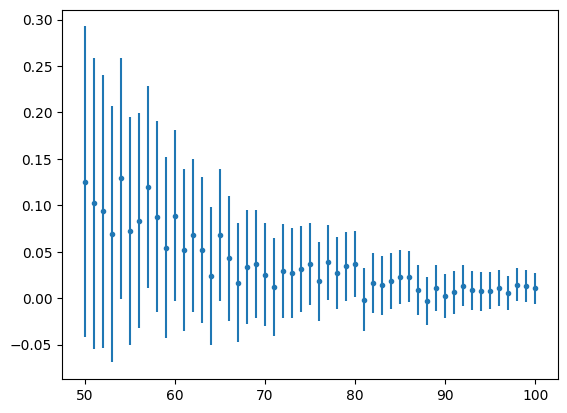

In [13]:
plt.errorbar(nuarr, rec-tot, err, fmt='.')

In [55]:
basemap_err = 10
err_type='idx'

nside = 32
lmax  = 5
lmod  = 5
Nlmax = RS.get_size(lmax)
Nlmod = RS.get_size(lmod)

# Observation and binning params.
Ntau  = None
Nt    = 24
times = np.linspace(0, 24, Nt, endpoint=False)
nuarr = np.linspace(50,100,51)
lats = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])

# Cosmological parameters.
cm21_params = OBS.cm21_params

# Foreground correction reference frequency.
err_ref = 70

# Generate foreground and 21-cm signal alm
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_params)
fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, 
    use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err, ref_freq=err_ref), 
    err_type=err_type, seed=100, meancorr=False)
fid_alm = fg_alm + cm21_alm

# Generate observation matrix for the modelling and for the observations.
narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)
mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)
mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))

# Perform fiducial observations
d = mat_A @ fid_alm
dnoisy, noise_covar = SM.add_noise(d, 1, Ntau=len(times), t_int=200, seed=456)

# Reconstruct the max likelihood estimate of the alm
mat_W, cov = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=noise_covar, cov=True, cond=True)
alm_error = np.sqrt(cov.diag)
rec_alm = mat_W @ (dnoisy)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 21
1/condition #: 6.898122468659319e-08


<ErrorbarContainer object of 3 artists>

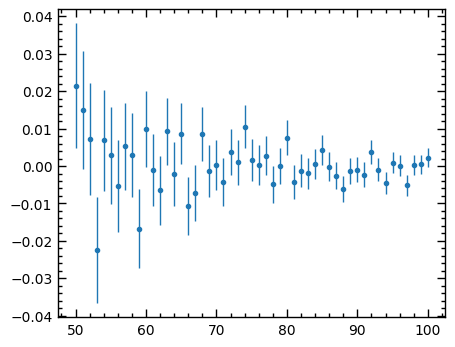

In [56]:
rec = rec_alm[0]
tot = BlockVector(fid_alm, nblock=len(nuarr))[0]
fgs = BlockVector(fg_alm, nblock=len(nuarr))[0]
c21 = BlockVector(cm21_alm, nblock=len(nuarr))[0]
err = BlockVector(alm_error, nblock=len(nuarr))[0]
plt.errorbar(nuarr, rec-tot, err, fmt='.')